In [1]:
!nvidia-smi

Fri Oct 22 23:44:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.13       Driver Version: 496.13       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A    0C    P8    N/A /  N/A |     75MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount ('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!ls

# Data Preprocessing

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
%cd  '/content/drive/MyDrive/RNNs Frozen desert Production forecast'

In [ ]:
!ls

In [5]:
#Read parse dataes reset index
df = pd.read_csv('Frozen_Dessert_Production.csv' , parse_dates=True , index_col='DATE')

In [6]:
#change column name
df.columns = ['Sale']
df

,Sale
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632


<AxesSubplot:xlabel='DATE'>

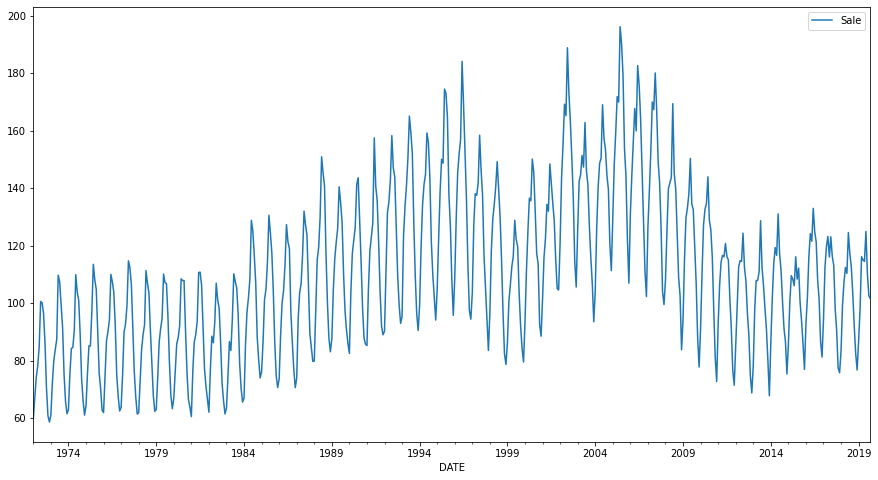

In [7]:
df.plot(figsize = (15,8))

In [8]:
#Data is montly and One pattern is repeated in one Year 
#So for forecasting we Choose 2 years for test and 12 months as length

## Splitting 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sale    573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [10]:
len(df)

573

In [11]:
#We need 24 months of data for test as data is montly first day only
#we choose last 24 rows of daata for test
573-24

549

In [12]:
train  = df.iloc[:549]
test = df.iloc[549:]

In [13]:
len(test)

24

## Scaling

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler =  MinMaxScaler()
scaler.fit(train)

train_scaler = scaler.transform(train)
test_scaler = scaler.transform(test)

In [16]:
test_scaler

array([[0.23134679],
       [0.13655347],
       [0.12472921],
       [0.18015997],
       [0.29691617],
       [0.35382169],
       [0.39102302],
       [0.37592272],
       [0.47940099],
       [0.42586022],
       [0.3928192 ],
       [0.32470899],
       [0.2434103 ],
       [0.17289089],
       [0.13163033],
       [0.20608099],
       [0.28689318],
       [0.41822681],
       [0.40948951],
       [0.40651527],
       [0.48213817],
       [0.37525952],
       [0.3195946 ],
       [0.31216335]])

## Creating Batches 

In [17]:
import tensorflow
import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
#TimeSeries Generator to create batches
length = 12   #one pattern in 12 units of data in df (i-e 1 year)
batch_size = 1

In [19]:
train_generator = TimeseriesGenerator(train_scaler, train_scaler, length = length, batch_size=batch_size)

test_generator = TimeseriesGenerator(test_scaler, test_scaler, length = length, batch_size=batch_size)

In [20]:
test_generator[1]

(array([[[0.13655347],
         [0.12472921],
         [0.18015997],
         [0.29691617],
         [0.35382169],
         [0.39102302],
         [0.37592272],
         [0.47940099],
         [0.42586022],
         [0.3928192 ],
         [0.32470899],
         [0.2434103 ]]]),
 array([[0.17289089]]))

# Train

## Early Stoppings

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
earlystop  = EarlyStopping(monitor='val_loss',  patience=2, verbose=1, mode='min')

## Train Config

In [23]:
from tensorflow.keras.layers import Dense , LSTM 
from tensorflow.keras.models import Sequential

In [167]:
n_features = 1    #predicting how many features for timeseries(here it is one)

model = Sequential()

model.add(LSTM(units= 128 , activation='relu' , input_shape=(length,n_features)))

model.add(Dense(32 , activation='elu' ))
#output
model.add(Dense(1))        #Taking one batch of data as output


In [168]:
model.compile(optimizer='adam', loss='mse')

In [169]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dense_31 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 33        
Total params: 70,721
Trainable params: 70,721
Non-trainable params: 0
_________________________________________________________________


In [170]:
#fitting

model.fit(train_generator , validation_data=test_generator , epochs= 10 , callbacks=[earlystop])

Epoch 1/10
537/537 [==============================] - 2s 3ms/step - loss: 0.0177 - val_loss: 0.0051
Epoch 2/10
537/537 [==============================] - 2s 3ms/step - loss: 0.0047 - val_loss: 0.0020
Epoch 3/10
537/537 [==============================] - 1s 3ms/step - loss: 0.0044 - val_loss: 0.0026
Epoch 4/10
537/537 [==============================] - 1s 3ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 00004: early stopping


<AxesSubplot:>

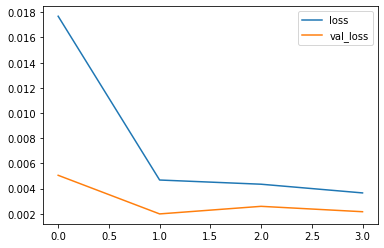

In [171]:
#plotting losses
loss = pd.DataFrame(model.history.history)
loss.plot()

# Test

In [172]:
test_predictions  = []

#take last no of lenght (18) values from train-scaled to forecast future
first_eval_batch = train_scaler[-length:]
#reshape it in form in which we trained our data input shape
current_batch = first_eval_batch.reshape((1,length,n_features))

#creating loop which predicts future values then from array delete last value
#append the predicted value at top and run for no of instances in test data
#wil run for 18 values
for i in range(len(test)):
  #getting prediction on current batch
  current_pred = model.predict(current_batch)[0]
  #appending predictions in array
  test_predictions.append(current_pred)

  #remove last length dimension value form batch anda add predictins at the top
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1  )

In [173]:
#Values for forecast
test_predictions

[array([0.22046909], dtype=float32),
 array([0.1698463], dtype=float32),
 array([0.16528219], dtype=float32),
 array([0.22607544], dtype=float32),
 array([0.3133251], dtype=float32),
 array([0.39084187], dtype=float32),
 array([0.44427395], dtype=float32),
 array([0.4812165], dtype=float32),
 array([0.48483527], dtype=float32),
 array([0.44504008], dtype=float32),
 array([0.36731786], dtype=float32),
 array([0.26419568], dtype=float32),
 array([0.166423], dtype=float32),
 array([0.1042873], dtype=float32),
 array([0.10208407], dtype=float32),
 array([0.16140038], dtype=float32),
 array([0.25532463], dtype=float32),
 array([0.34225023], dtype=float32),
 array([0.4090008], dtype=float32),
 array([0.4555996], dtype=float32),
 array([0.4730935], dtype=float32),
 array([0.44414362], dtype=float32),
 array([0.36897323], dtype=float32),
 array([0.26313928], dtype=float32)]

**Inverse values form scaled form**

In [174]:
true_pred = scaler.inverse_transform(test_predictions)

In [175]:
true_pred

array([[ 88.97736403],
       [ 82.01602661],
       [ 81.38839853],
       [ 89.74831554],
       [101.74635744],
       [112.40599003],
       [119.75364335],
       [124.83375632],
       [125.33138843],
       [119.85899664],
       [109.17111083],
       [ 94.9903784 ],
       [ 81.54527481],
       [ 73.00075389],
       [ 72.69777865],
       [ 80.85459541],
       [ 93.7704859 ],
       [105.72396362],
       [114.90309703],
       [121.31107866],
       [123.71673358],
       [119.73572177],
       [109.39874721],
       [ 94.84510832]])

<AxesSubplot:xlabel='DATE'>

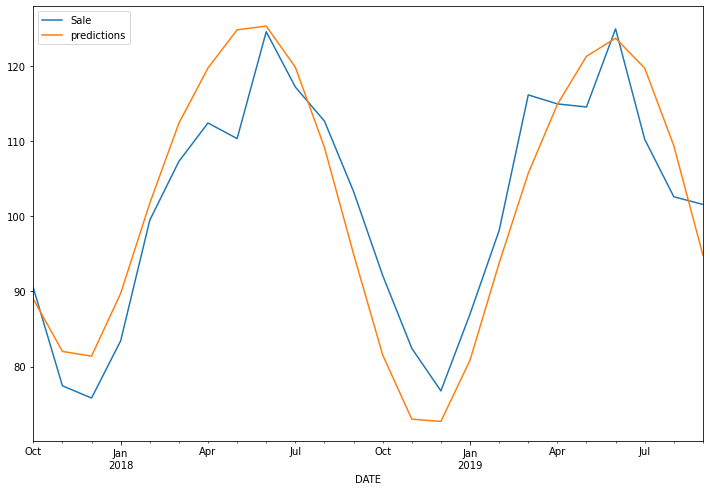

In [176]:
#Connecting this col with test so that it can be plotted
test['predictions'] = true_pred
test.plot(figsize=  (12,8))


# Future Trends Predictions

**Retrain data on Full Dataframe**

In [177]:
#creating full scaled dataframe
scaler.fit(df)
full_scaled = scaler.transform(df)

In [178]:
#Generator for fullscaled data
full_scaled_generator = TimeseriesGenerator(full_scaled,full_scaled,length = length , batch_size=1)

In [179]:
#Training using above tested configurations
n_features = 1    #predicting how many features for timeseries(here it is one)

model = Sequential()

model.add(LSTM(units= 128 , activation='relu' , input_shape=(length,n_features)))

model.add(Dense(32 , activation='elu' ))
#output
model.add(Dense(1))        #Taking one batch of data as output


In [180]:
model.compile(optimizer='adam', loss='mse')

In [181]:
model.fit(full_scaled_generator , epochs=8  )

Epoch 1/8
561/561 [==============================] - 2s 3ms/step - loss: 0.0151
Epoch 2/8
561/561 [==============================] - 1s 3ms/step - loss: 0.0048
Epoch 3/8
561/561 [==============================] - 2s 3ms/step - loss: 0.0036
Epoch 4/8
561/561 [==============================] - 1s 3ms/step - loss: 0.0035
Epoch 5/8
561/561 [==============================] - 2s 3ms/step - loss: 0.0033
Epoch 6/8
561/561 [==============================] - 2s 3ms/step - loss: 0.0032
Epoch 7/8
561/561 [==============================] - 2s 3ms/step - loss: 0.0036
Epoch 8/8
561/561 [==============================] - 1s 3ms/step - loss: 0.0038


In [182]:
#Future Predictions making

forecasting  = []

#take last no of lenght (18) values from train-scaled to forecast future
first_eval_batch = train_scaler[-length:]
#reshape it in form in which we trained our data input shape
current_batch = first_eval_batch.reshape((1,length,n_features))

#creating loop which predicts future values then from array delete last value
#append the predicted value at top and run for no of instances in test data
#wil run for 18 values
for i in range(12):  
  #getting prediction on current batch
  current_pred = model.predict(current_batch)[0]
  #appending predictions in array
  forecasting.append(current_pred)

  #remove last length dimension value form batch anda add predictins at the top
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1  )





In [183]:
forecasting

[array([0.22958687], dtype=float32),
 array([0.19388323], dtype=float32),
 array([0.21860729], dtype=float32),
 array([0.29630482], dtype=float32),
 array([0.37967637], dtype=float32),
 array([0.44210997], dtype=float32),
 array([0.4899421], dtype=float32),
 array([0.5150622], dtype=float32),
 array([0.51524395], dtype=float32),
 array([0.4568123], dtype=float32),
 array([0.36215335], dtype=float32),
 array([0.2550357], dtype=float32)]

In [184]:
#Inverse scale
true_full_pred = scaler.inverse_transform(forecasting)

**Creating Index for our forecasts**

In [185]:
df.tail()

,Sale
DATE,
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632
2019-08-01,102.6085
2019-09-01,101.5866


In [186]:
#using pandas timeseries
forecast_index = pd.date_range('2019-10-01' , periods = 12 , freq = 'MS')

In [187]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [188]:
#Append it with actual forecasts
forecasts = pd.DataFrame(true_full_pred , index =  forecast_index ,columns=['Forecasts'] )

In [189]:
#Our FUTURE FORECAST variable
forecasts

,Forecasts
2019-10-01,90.231186
2019-11-01,85.321438
2019-12-01,88.721341
2020-01-01,99.405832
2020-02-01,110.870579
2020-03-01,119.456067
2020-04-01,126.033649
2020-05-01,129.488014
2020-06-01,129.513005
2020-07-01,121.477840


<AxesSubplot:>

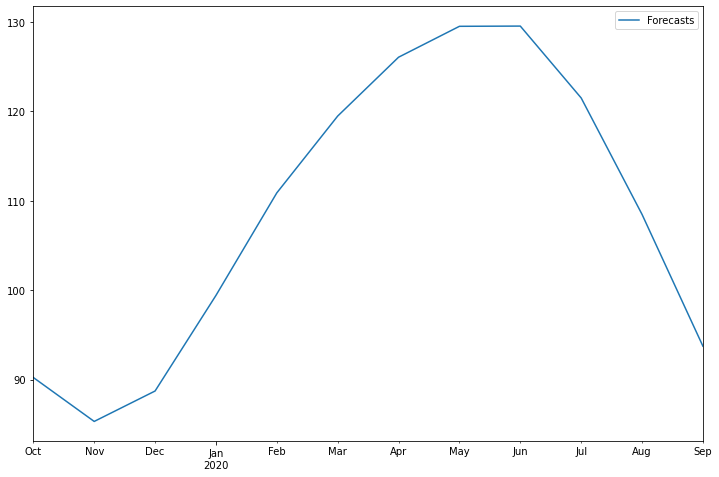

In [190]:
forecasts.plot(figsize = (12,8))

<AxesSubplot:xlabel='DATE'>

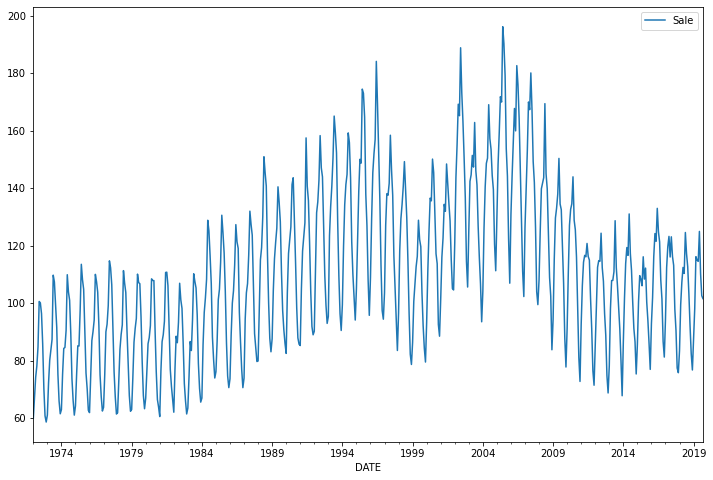

In [191]:
df.plot(figsize = (12,8))

# Forecast

<AxesSubplot:xlabel='DATE'>

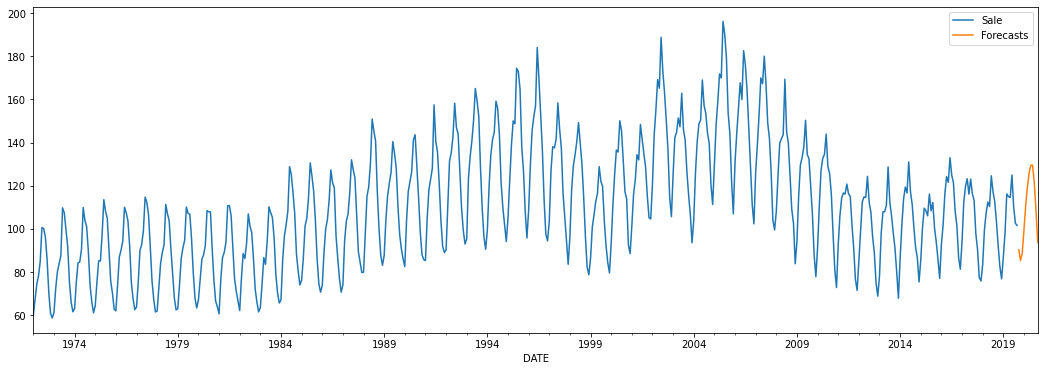

In [192]:
ax = df.plot()
forecasts.plot(ax = ax , figsize = (18,6))

In [193]:
#Concatting in one column
#name should be same
forecasts.columns = ['Sale']

concatted_df = pd.concat([df ,forecasts] )
len(concatted_df)

585

In [194]:
concatted_df

,Sale
1972-01-01,59.962200
1972-02-01,67.060500
1972-03-01,74.235000
1972-04-01,78.112000
1972-05-01,84.763600
...,...
2020-05-01,129.488014
2020-06-01,129.513005
2020-07-01,121.477840
2020-08-01,108.460920


In [195]:
#plotly and cufflinks configuration and imports
import plotly.express as px
from plotly import graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

#plotly offline configure
import plotly as py
py.offline.init_notebook_mode(connected=True)

In [196]:
fig = px.line(  data_frame=concatted_df,
    x=concatted_df.index,
    y='Sale',title="Confirmed,Active,Deaths and Recoveries" ,  color_discrete_sequence=px.colors.carto.Vivid,
            )
fig.show()

# Save

In [ ]:
# model.save('FrozenDesertForecast.h5')